# An Entropic Analysis of Grover's Algorithm

## Goal: 
Analyze the entropy for partitions of a quantum register during the steps of Grover's algorithm on that register

## Motivation: 

Grover's algorithm essentially takes a uniform quantum state and iteratively updates it until the state is a given goal state. We want to check how the entropies of all bipartitions of the overall Hilbert space, defined as the **entropy vector**, act throughout the algorithm, and make checks of subadditivity, strong subadditivity, and monogamy of mutual information with these entropies.

## Introduction and definitions:

We define a **qubit** as a basic unit of quantum information, which is a two-state system completely described as a vector in Hilbert space $\mathcal{H} = \mathbb{C}^2$. A **quantum register** of $N$ qubits is then described by the tensor product structure $\mathcal{H}^1=\mathbb{C}^2\otimes \mathbb{C}^2\otimes ... = \mathbb{C}^{2N}$. Therefore, at any given point, the state of the quantum register is a single vector living in this Hilbert space $\ket{\psi}\in\mathcal{H}$.

We now define the **density matrix** $\rho$ as an operator which depends on the state of the system:$$\rho=\ket{\psi}\bra{\psi}$$

Given a density matrix, the **Von Neumann Entropy** is defined as $S=-tr(\rho\ln\rho)$, which is equivalent to the **Shannon entropy** $-\sum_i p_i\ket{i}\bra{i}$ when written in the basis of its eigenvectors. This will give us a choice of how to compute the entropy by either using some implementation of the *matrix logarithm* or finding the eigenvalues of the density matrix.

Below are just the Python libraries I imported for this project.

In [1]:
import math
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit.library.standard_gates import ZGate
from qiskit.visualization import plot_histogram
from qiskit import quantum_info
from itertools import combinations
from itertools import chain, repeat
import matplotlib.pyplot as plt 
from tqdm.notebook import trange, tqdm

### Bipartitioning
Since the quantum register is using a tensor product structure, one might ask what the density matrix of a set of $M$ out of the original $N$ qubits looks like, which will help us analyze the entropy of that subsystem. Earlier we introduced the idea of an **entropy vector**. This entropy vector is the list of the entropy for every possible bipartition of the overall Hilbert space. 
We define the **Partial Trace** as this reduced density matrix. If the Hilbert space is bipartitioned as $\mathcal{H} = \mathcal{H}^A\otimes\mathcal{H}^{\bar{A}}$, then one can find the reduced density matrix, or partial trace of $\mathcal{H}^A$ by 'tracing out' $\mathcal{H}^{\bar{A}}$: $\rho^A=\text{Tr}_{\bar{A}}\rho$. Thus our first problem is writing an algorithm to produce all such bipartitions. The algorithm below generates all combinations of a list with a given size, starting at $0$ and ending at $N/2$, adding each combination and its complement to a list to return, containing every way to bipartition the input list. Each bipartition is a list of two elements, sorted according to Python's defsault `sort()` function, which is to avoid double counting and the the list of all bipartitions is sorted again to preserve lexicographic ordering.

In [2]:
#input
def bipartitioning(qubs):
    """
    Generate a list of all bipartitions of a list

    Parameters:
    qubs (list): list to find all bipartitions of
    
    Returns: 
    bipartitions (list): list of all bipartitions where each element has 2 lists, the list of elements in the first piece, and the remining list of its complement
    """

    #Number of elements in the overall system
    N=len(qubs)
    bipartitions = list()

    #Loop over number of elements in the first subsystem from 0 to N/2
    for size_A in range(math.ceil(N/2)+1):
        #Generates a tuple of all combinations that can be made of size_A qubits out of the system
        combs = combinations(qubs,size_A)
        #Loop over every possible combination
        for c in combs:
            combination = list(c)
            combination.sort()
            #Determine the complement of the combination that completes the system
            complement = qubs[:]
            for bit in combination:
                complement.remove(bit)
            complement.sort()
            #Each bipartition has 2 subsystems, the list of pieces in the first subsystem, and its complement
            new_bipartition = [combination,complement]
            new_bipartition.sort()
            #Do not store duplicate bipartitions
            if new_bipartition not in bipartitions:
                bipartitions.append(new_bipartition)
    bipartitions.sort()
    return bipartitions

### Tripartitioning

While we do not need tripartitioning to compute the entropy vector, it is useful to make checks of strong subadditivity and monogamy of mutual information. Here the algorithm finds all bipartitions using the above function, and finds all bipartitions of each piece in that bipartition, producing a list of tripartitions of the original list, again with each partition sorted as well as the overall list.

In [3]:
def tripartitioning(qubs):
    """
    Generate a list of all tripartitions of a list

    Parameters:
    qubs (list): list to find all tripartitions of
    
    Returns: 
    tripartitions (list): list of all bipartitions where each element has 2 lists, the list of elements in the first piece, and the remining list of its complement
    """
    tripartitions = list()
    #Bipartition a single piece of each bipartition to form a tripartition
    for bipartition in bipartitioning(qubs):
        for piece in range(2):
            for subpartition in bipartitioning(bipartition[piece]):
                new_tripartition = [subpartition[0],subpartition[1],bipartition[1-piece]]
                new_tripartition.sort()
                if new_tripartition not in tripartitions:
                    tripartitions.append(new_tripartition)
    tripartitions.sort()
    return tripartitions

### Shannon Entropy
I will elect to use Python's Numpy library to find the eigenvalues of the density matrix, and so the entropy is just the Shannon Entropy of the list of eigenvalues, or probability vector: 
$$H(\vec{p})=-\sum_i p_i\log(p_i)$$
Note that in order to avoid truncation issues, I set a manual cutoff of $10^{-10}$, which is allowed since $\lim_{p_i\to 0}p_i\log(p_i)=0$.

In [4]:
def shannon_ent(probs):
    sum = 0
    for p_i in probs:
        if p_i > 1e-10:
            sum = sum + p_i*math.log(p_i)
    return -1*sum

## The Analysis
Here I define an object which find the entropy of all subsystems, and calculates the saturation of the following inequalites:
$$$$


In [18]:
class EntropyAnalysis:
    def __init__(self,N):

        #These will all be populated with each call of subsystem_analysis()
        self.N = N
        self.avg_sas = []
        self.avg_ssas = []
        self.avg_mmis = []
        self.norms = []
        self.entropies = []
        self.single_qubit_entropy_series =[]
        for i in range(N):
            self.single_qubit_entropy_series.append([])

    def subsysem_analysis(self,circuit):
        N = circuit.num_qubits
        
        norm = 0
        entropy=[]
        p = quantum_info.DensityMatrix(circuit)
        subsystems = list(chain.from_iterable(bipartitioning(list(range(N)))))
        subsystems.sort()
        sum_sa = 0
        num_sa_checks = 0
        sum_ssa = 0
        num_ssa_checks = 0
        sum_mmi = 0
        
        for subsystem in subsystems:
            p_12 = quantum_info.partial_trace(p,subsystem)
            probs = np.linalg.eigvals(np.array(p_12.data)).tolist()
            e = shannon_ent([p_i.real for p_i in probs])
            entropy.append(e)
            norm = norm + e**2

            for subsystem_bipartition in bipartitioning(subsystem):
                p_1 = quantum_info.partial_trace(p,subsystem_bipartition[0])
                p_2 = quantum_info.partial_trace(p,subsystem_bipartition[1])
                probs_1 = np.linalg.eigvals(np.array(p_1.data)).tolist()
                probs_2 = np.linalg.eigvals(np.array(p_2.data)).tolist()
                e_1 = shannon_ent([p_i.real for p_i in probs_1])
                e_2 = shannon_ent([p_i.real for p_i in probs_2])
                sa_saturation = e_1+e_2-e
                num_sa_checks = num_sa_checks + 1
                sum_sa = sum_sa + sa_saturation
                if sa_saturation < -1e-10:
                    print("subadditivity failed for ",end="")
                    print(subsystem_bipartition)
                    print("Saturation: "+str(sa_saturation))
                
                # if len(subsystem_bipartition[0]) == 1 or len(subsystem_bipartition[1]) == 1:
                #     print("Bipartition: ",end="")
                #     print(subsystem_bipartition)
                #     print("SA Saturation: "+str(sa_saturation))
            for subsystem_tripartition in tripartitioning(subsystem):
                p_1 = quantum_info.partial_trace(p,subsystem_tripartition[0])
                probs_1 = np.linalg.eigvals(np.array(p_1.data)).tolist()
                e_1 = shannon_ent([p_i.real for p_i in probs_1])
                p_2 = quantum_info.partial_trace(p,subsystem_tripartition[1])
                probs_2 = np.linalg.eigvals(np.array(p_2.data)).tolist()
                e_2 = shannon_ent([p_i.real for p_i in probs_2])
                p_3 = quantum_info.partial_trace(p,subsystem_tripartition[2])
                probs_3 = np.linalg.eigvals(np.array(p_3.data)).tolist()
                e_3 = shannon_ent([p_i.real for p_i in probs_3])
                p_12 = quantum_info.partial_trace(p,subsystem_tripartition[0]+subsystem_tripartition[1])
                probs_12 = np.linalg.eigvals(np.array(p_12.data)).tolist()
                e_12 = shannon_ent([p_i.real for p_i in probs_12])
                p_13 = quantum_info.partial_trace(p,subsystem_tripartition[0]+subsystem_tripartition[2])
                probs_13 = np.linalg.eigvals(np.array(p_13.data)).tolist()
                e_13 = shannon_ent([p_i.real for p_i in probs_13])
                p_23  = quantum_info.partial_trace(p,subsystem_tripartition[1]+subsystem_tripartition[2])
                probs_23 = np.linalg.eigvals(np.array(p_23.data)).tolist()
                e_23 = shannon_ent([p_i.real for p_i in probs_23])
                ssa_saturation = e_12+e_23-e_2-e
                sum_ssa = sum_ssa + ssa_saturation
                num_ssa_checks = num_ssa_checks + 1
                if ssa_saturation < -1e-10:
                    print("strong subadditivity failed for ",end="")
                    print(subsystem_tripartition)
                    print("Saturation: "+str(ssa_saturation))
                mmi_saturation = e_12+e_13+e_23-e_1-e_2-e_3-e
                sum_mmi = sum_mmi + mmi_saturation
        self.entropies.append(entropy)
        self.norms.append(math.sqrt(norm))
        self.avg_sas.append(sum_sa/num_sa_checks)
        self.avg_ssas.append(sum_ssa/num_ssa_checks)
        self.avg_mmis.append(sum_mmi/num_ssa_checks)
        for i in range(len(subsystems)):
            if len(subsystems[i]) == 1:
                self.single_qubit_entropy_series[subsystems[i][0]].append(entropy[i])

    def plot_saturations(self):
        plt.plot(self.avg_sas, label="Average SA Saturation")
        plt.plot(self.avg_ssas, label="Average SSA Saturation")
        plt.plot(self.avg_mmis, label="Average MMI Saturation")
        plt.legend()
        plt.show()
    
    def plot_single_qubit_entropy(self):
        t=np.arange(len(self.avg_mmis))
        for i in range(self.N):
            plt.plot(t,self.single_qubit_entropy_series[i], label="q"+str(i))
        plt.legend()
        plt.show()

    def set_circuit(self,circuit):
        self.circuit = circuit
    
    def set_statevec(self,statevec):
        self.statevec = statevec

    

### Grover's Algorithm

In [6]:
def grovers(goal_state, num_iterations):
        # Num bits needed to specify goal state
        N = len(goal_state)

        # Create controlled z gate for goal state
        cnz = ZGate().control(N, ctrl_state=goal_state)

        # Create controlled z gate for zero state
        cnz0 = ZGate().control(N, ctrl_state="0"*N)

        # Construct the circuit

        qr = QuantumRegister(N+1) #+1 for ancilla
        cr = ClassicalRegister(N)
        groverCircuit = QuantumCircuit(qr,cr) 

        # Instantiate Analysis object
        groverAnalysis = EntropyAnalysis(groverCircuit.num_qubits)


        # Begin the algorithm

        # h on all except ancilla
        for qubit in range(N):
            groverCircuit.h(qubit)
            # Do this after every 'gate' applied
            groverAnalysis.subsysem_analysis(groverCircuit) 

        # NOT on ancilla
        groverCircuit.x(N)
        groverAnalysis.subsysem_analysis(groverCircuit)
        
        # grover iteration
        for grover_iteration in trange(num_iterations):
            # phase flip ancilla controlled by bitstring of goal state
            groverCircuit.append(cnz,qr)
            groverAnalysis.subsysem_analysis(groverCircuit)
            
            # h on all except ancilla
            for qubit in range(N):
                groverCircuit.h(qubit)
                groverAnalysis.subsysem_analysis(groverCircuit)

            # phase flip ancilla if state is all zeros
            groverCircuit.append(cnz0,qr)
            groverAnalysis.subsysem_analysis(groverCircuit)

            # h on all except ancilla
            for qubit in range(N):
                groverCircuit.h(qubit)
                groverAnalysis.subsysem_analysis(groverCircuit)
            
        #measure all but ancilla
        groverCircuit.measure(qr[:-1],cr)
        
        groverAnalysis.set_circuit(groverCircuit)
        return groverAnalysis

        

In [7]:
goal='10101'
num_iterations=18
groverAnalysis = grovers(goal,num_iterations)

  0%|          | 0/18 [00:00<?, ?it/s]

I can plot the saturations of these inequalities as gates are applied in Grover's algorithm

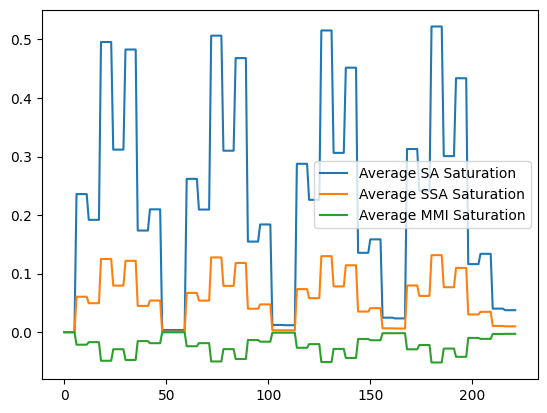

In [8]:
groverAnalysis.plot_saturations()

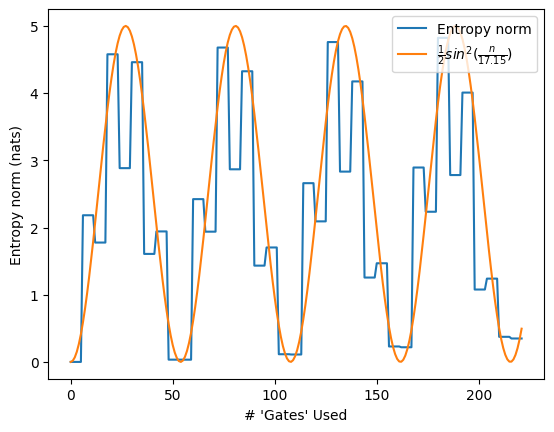

In [9]:
plt.plot(groverAnalysis.norms, label="Entropy norm")
t = np.arange(len(groverAnalysis.avg_mmis))
plt.plot(5*np.sin(t/17.15)**2,label=r'$\frac{1}{2}sin^2(\frac{n}{17.15})$')
plt.xlabel("# 'Gates' Used")
plt.ylabel("Entropy norm (nats)")
plt.legend()

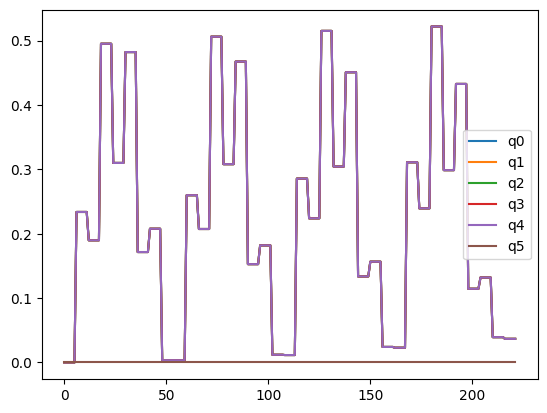

In [10]:
groverAnalysis.plot_single_qubit_entropy()

In [11]:
def qft(initial_state):
        
        N = int(np.log2(len(initial_state)))
        
        # Construct the circuit
        qr = QuantumRegister(N) #+1 for ancilla
        cr = ClassicalRegister(N)
        qftCircuit = QuantumCircuit(qr,cr) 
        qftCircuit.initialize(initial_state,qftCircuit.qubits)

        qftAnalysis = EntropyAnalysis(N)
        
        # Begin the QFT

        for i in range(N):
            qftCircuit.h(i)
            #self.subsysem_analysis(qftCircuit)
            qftCircuit.barrier()
            
            for k in range(2,N-i+1):
                qftCircuit.cp(2*np.pi/2**k,i+(k-1),i)
                #self.subsysem_analysis(qftCircuit)
                qftCircuit.barrier()
        #for ease i check if the actual statevector is indeed correct, rather than simulaitng, measuring, and taking square roots
        qftAnalysis.statevec = quantum_info.Statevector(qftCircuit) 
        qftCircuit.measure(qr,cr)
        qftAnalysis.set_circuit(qftCircuit)
        
        return qftAnalysis

     

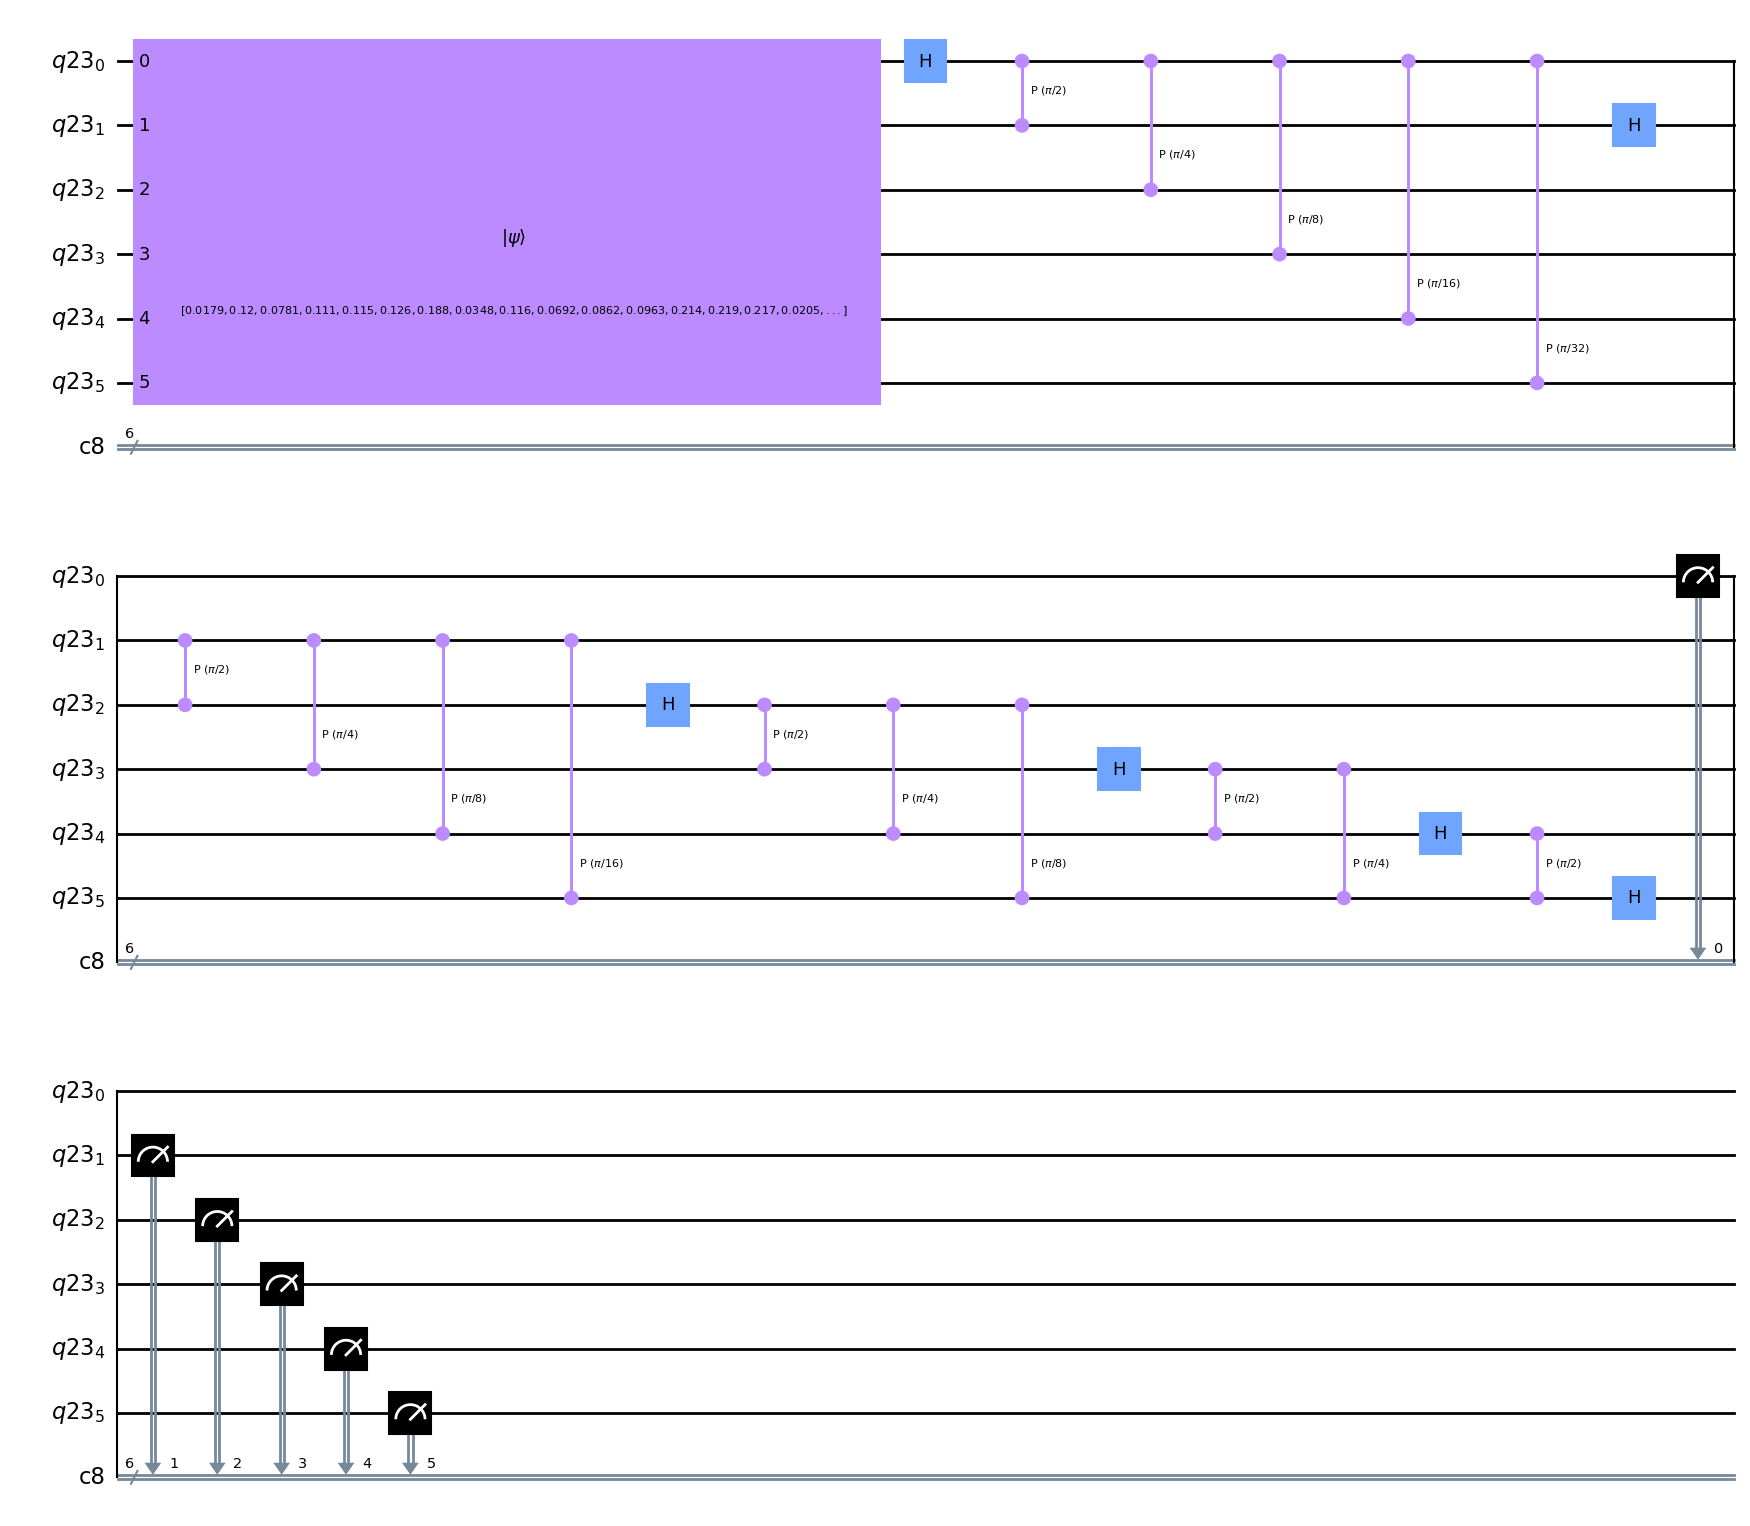

In [23]:
size_list = 2**6
init = np.random.rand(1,size_list)[0]
init = init/np.linalg.norm(init)
qftanalysis = qft(init)
qftanalysis.circuit.draw('mpl',plot_barriers=False,style="clifford")

In [24]:
def dft(x):
    N=len(x)
    y = np.repeat(0+0j,N)
    for k in range(N):
        for n in range(N):
            y[k] = y[k] + x[n]*np.exp(1j*2*np.pi*k*n/N)
    return y/N**.5

dft_result = dft(init)
#here i check if dft is off from qft:

fails = 0
for i in range(len(init)):
    if abs(qftanalysis.statevec[i] - dft_result[i]) > 1e-2:
        fails = fails+1
print("Fail %",fails/len(init)*100)




            


Fail % 92.1875
